In [44]:
import pandas as pd
import mwclient
from datetime import datetime
import time
from tqdm.notebook import tqdm

### Downloading Edits from wikipedia

In [2]:
site = mwclient.Site('en.wikipedia.org')
page = site.pages["Bitcoin"]

In [3]:
revs = list(page.revisions())

In [4]:
revs[0]

OrderedDict([('revid', 1109601510),
             ('parentid', 1109601379),
             ('minor', ''),
             ('user', 'Eden5'),
             ('timestamp',
              time.struct_time(tm_year=2022, tm_mon=9, tm_mday=10, tm_hour=20, tm_min=45, tm_sec=38, tm_wday=5, tm_yday=253, tm_isdst=-1)),
             ('comment',
              'Undid revision 1109601379 by [[Special:Contributions/Staxringold|Staxringold]] ([[User talk:Staxringold|talk]])')])

In [5]:
len(revs)

16985

In [6]:
revs = sorted(revs, key=lambda rev : rev['timestamp'])

In [7]:
revs[0]

OrderedDict([('revid', 275832581),
             ('parentid', 0),
             ('user', 'Pratyeka'),
             ('timestamp',
              time.struct_time(tm_year=2009, tm_mon=3, tm_mday=8, tm_hour=16, tm_min=41, tm_sec=7, tm_wday=6, tm_yday=67, tm_isdst=-1)),
             ('comment', 'creation (stub)')])

### Sentiment of edits

In [10]:
from transformers import pipeline
"""Transformers contain lots of pre-trained deep learning models and in 
    this case we are using sentiment analysis model"""
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [11]:
def find_sentiment(text):
    sent = sentiment_pipeline([text[:250]])[0]
    score = sent["score"]
    if sent["label"] == "NEGATIVE":
        score *= -1
    return score

In [16]:
find_sentiment("I hate you")

-0.9991129040718079

In [29]:
edits = {}

for rev in tqdm(revs):
#     print(rev)
    date = time.strftime("%Y-%m-%d", rev["timestamp"])
    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0)
    
    edits[date]["edit_count"] += 1
    if "comment" in rev:
        comment = rev["comment"]
    elif "commenthidden" in rev:
        comment = rev["commenthidden"]
    edits[date]["sentiments"].append(find_sentiment(comment))

  0%|          | 0/16985 [00:00<?, ?it/s]

In [30]:
edits

{'2009-03-08': {'sentiments': [-0.9905919432640076,
   0.7481209635734558,
   -0.9907428622245789,
   -0.9688860774040222],
  'edit_count': 4},
 '2009-08-05': {'sentiments': [0.7481209635734558], 'edit_count': 1},
 '2009-08-06': {'sentiments': [0.9957457184791565, 0.9957457184791565],
  'edit_count': 2},
 '2009-08-14': {'sentiments': [0.930020809173584], 'edit_count': 1},
 '2009-10-13': {'sentiments': [0.5404344797134399, -0.9954361319541931],
  'edit_count': 2},
 '2009-11-18': {'sentiments': [0.8839507699012756], 'edit_count': 1},
 '2009-12-08': {'sentiments': [-0.9869275689125061], 'edit_count': 1},
 '2009-12-17': {'sentiments': [-0.9975171089172363], 'edit_count': 1},
 '2010-02-23': {'sentiments': [-0.9994946718215942], 'edit_count': 1},
 '2010-03-18': {'sentiments': [0.8758772015571594], 'edit_count': 1},
 '2010-04-13': {'sentiments': [0.930020809173584,
   0.8158000111579895,
   0.8158000111579895,
   0.8158000111579895],
  'edit_count': 4},
 '2010-04-15': {'sentiments': [0.930020

In [33]:
from statistics import mean

In [34]:
for key in edits:
    if len(edits[key]['sentiments']) > 0:
        edits[key]['sentiment'] = mean(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]['sentiments'] if s < 0])/len(edits[key]["sentiments"])
    else:
        edits[key]['sentiment'] = 0
        edits[key]['neg_sentiment'] = 0
    
    del edits[key]["sentiments"]

In [37]:
edits

{'2009-03-08': {'edit_count': 4,
  'sentiment': -0.5505249798297882,
  'neg_sentiment': 0.75},
 '2009-08-05': {'edit_count': 1,
  'sentiment': 0.7481209635734558,
  'neg_sentiment': 0.0},
 '2009-08-06': {'edit_count': 2,
  'sentiment': 0.9957457184791565,
  'neg_sentiment': 0.0},
 '2009-08-14': {'edit_count': 1,
  'sentiment': 0.930020809173584,
  'neg_sentiment': 0.0},
 '2009-10-13': {'edit_count': 2,
  'sentiment': -0.2275008261203766,
  'neg_sentiment': 0.5},
 '2009-11-18': {'edit_count': 1,
  'sentiment': 0.8839507699012756,
  'neg_sentiment': 0.0},
 '2009-12-08': {'edit_count': 1,
  'sentiment': -0.9869275689125061,
  'neg_sentiment': 1.0},
 '2009-12-17': {'edit_count': 1,
  'sentiment': -0.9975171089172363,
  'neg_sentiment': 1.0},
 '2010-02-23': {'edit_count': 1,
  'sentiment': -0.9994946718215942,
  'neg_sentiment': 1.0},
 '2010-03-18': {'edit_count': 1,
  'sentiment': 0.8758772015571594,
  'neg_sentiment': 0.0},
 '2010-04-13': {'edit_count': 4,
  'sentiment': 0.844355210661888

In [38]:
edits_df = pd.DataFrame.from_dict(edits, orient='index')

In [39]:
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.750000
2009-08-05,1,0.748121,0.000000
2009-08-06,2,0.995746,0.000000
2009-08-14,1,0.930021,0.000000
2009-10-13,2,-0.227501,0.500000
...,...,...,...
2022-09-01,1,-0.995530,1.000000
2022-09-02,3,-0.353947,0.666667
2022-09-06,1,0.809336,0.000000
2022-09-08,1,-0.978057,1.000000


In [40]:
edits_df.index = pd.to_datetime(edits_df.index)

In [42]:
edits_df.head(5)

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.75
2009-08-05,1,0.748121,0.00
2009-08-06,2,0.995746,0.00
2009-08-14,1,0.930021,0.00
2009-10-13,2,-0.227501,0.50


In [45]:
dates = pd.date_range(start="2009-03-08", end=datetime.today())

In [46]:
dates

DatetimeIndex(['2009-03-08', '2009-03-09', '2009-03-10', '2009-03-11',
               '2009-03-12', '2009-03-13', '2009-03-14', '2009-03-15',
               '2009-03-16', '2009-03-17',
               ...
               '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06',
               '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10',
               '2022-09-11', '2022-09-12'],
              dtype='datetime64[ns]', length=4937, freq='D')

In [47]:
edits_df = edits_df.reindex(dates, fill_value=0)

In [48]:
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.750000
2009-03-09,0,0.000000,0.000000
2009-03-10,0,0.000000,0.000000
2009-03-11,0,0.000000,0.000000
2009-03-12,0,0.000000,0.000000
...,...,...,...
2022-09-08,1,-0.978057,1.000000
2022-09-09,0,0.000000,0.000000
2022-09-10,3,-0.412538,0.666667
2022-09-11,0,0.000000,0.000000


In [51]:
rolling_edits = edits_df.rolling(30).mean() ## avergare of previous 30 days

In [52]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2009-03-08,NaN,NaN,NaN
2009-03-09,NaN,NaN,NaN
2009-03-10,NaN,NaN,NaN
2009-03-11,NaN,NaN,NaN
2009-03-12,NaN,NaN,NaN
...,...,...,...
2022-09-08,0.466667,-0.114104,0.183333
2022-09-09,0.466667,-0.114104,0.183333
2022-09-10,0.566667,-0.127855,0.205556
2022-09-11,0.566667,-0.127855,0.205556


In [53]:
rolling_edits = rolling_edits.dropna()

In [54]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2022-09-08,0.466667,-0.114104,0.183333
2022-09-09,0.466667,-0.114104,0.183333
2022-09-10,0.566667,-0.127855,0.205556
2022-09-11,0.566667,-0.127855,0.205556


In [55]:
rolling_edits.to_csv('wikipedia_edits.csv')

### Download the Bitcoin Price data

In [57]:
import yfinance as yf
import os

In [74]:
btc_ticker = yf.Ticker("BTC-INR")

In [75]:
btc = btc_ticker.history(period="max")

In [76]:
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,2.844333e+04,2.854223e+04,2.755250e+04,2.785164e+04,1282359120,0,0
2014-09-18,2.782277e+04,2.782277e+04,2.508574e+04,2.577412e+04,2093992320,0,0
2014-09-19,2.575365e+04,2.598884e+04,2.336609e+04,2.402334e+04,2307413745,0,0
2014-09-20,2.401585e+04,2.575756e+04,2.372438e+04,2.488181e+04,2243150060,0,0
2014-09-21,2.483197e+04,2.509612e+04,2.392506e+04,2.426826e+04,1617399085,0,0
...,...,...,...,...,...,...,...
2022-09-08,1.536420e+06,1.548534e+06,1.522294e+06,1.540632e+06,2565973867551,0,0
2022-09-09,1.540497e+06,1.707779e+06,1.539128e+06,1.703138e+06,3860891789542,0,0
2022-09-10,1.702801e+06,1.733359e+06,1.686238e+06,1.727008e+06,2940439544778,0,0


In [61]:
# ??yf

In [62]:
# ??yf.Ticker

In [77]:
btc.index = pd.to_datetime(btc.index)

In [78]:
del btc['Dividends']
del btc['Stock Splits']

In [79]:
btc.columns = btc.columns.str.lower()

In [80]:
btc.head()

,open,high,low,close,volume
Date,,,,,
2014-09-17,28443.328125,28542.228516,27552.500000,27851.640625,1282359120
2014-09-18,27822.773438,27822.773438,25085.740234,25774.119141,2093992320
2014-09-19,25753.654297,25988.835938,23366.087891,24023.335938,2307413745
2014-09-20,24015.851562,25757.560547,23724.380859,24881.808594,2243150060
2014-09-21,24831.972656,25096.121094,23925.064453,24268.257812,1617399085


<AxesSubplot:xlabel='Date'>

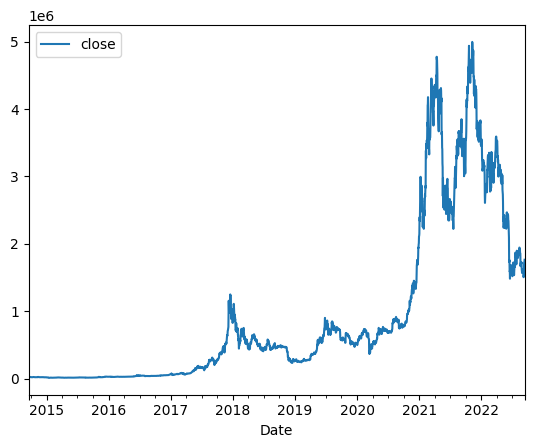

In [81]:
btc.plot.line(y="close", use_index=True)

In [82]:
wiki = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True)

In [83]:
wiki.head()

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025
2009-04-07,0.000000,0.000000,0.000
2009-04-08,0.000000,0.000000,0.000
2009-04-09,0.000000,0.000000,0.000
2009-04-10,0.000000,0.000000,0.000


In [84]:
btc = btc.merge(wiki, left_index=True, right_index=True)

In [85]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
2014-09-17,2.844333e+04,2.854223e+04,2.755250e+04,2.785164e+04,1282359120,5.033333,-0.232191,0.532718
2014-09-18,2.782277e+04,2.782277e+04,2.508574e+04,2.577412e+04,2093992320,5.066667,-0.232760,0.532718
2014-09-19,2.575365e+04,2.598884e+04,2.336609e+04,2.402334e+04,2307413745,5.200000,-0.235415,0.549385
2014-09-20,2.401585e+04,2.575756e+04,2.372438e+04,2.488181e+04,2243150060,5.200000,-0.233185,0.549385
2014-09-21,2.483197e+04,2.509612e+04,2.392506e+04,2.426826e+04,1617399085,5.233333,-0.204017,0.532718
...,...,...,...,...,...,...,...,...
2022-09-08,1.536420e+06,1.548534e+06,1.522294e+06,1.540632e+06,2565973867551,0.466667,-0.114104,0.183333
2022-09-09,1.540497e+06,1.707779e+06,1.539128e+06,1.703138e+06,3860891789542,0.466667,-0.114104,0.183333
2022-09-10,1.702801e+06,1.733359e+06,1.686238e+06,1.727008e+06,2940439544778,0.566667,-0.127855,0.205556
2022-09-11,1.726849e+06,1.734156e+06,1.705193e+06,1.734053e+06,2747652410708,0.566667,-0.127855,0.205556


In [88]:
btc.iloc[-1]['open']

1733150.0